In [1]:
# python libraries/modules and some useful "constants" used in this notebook (with some holdovers from other, similar notebooks)
import pandas as pd
pd.set_option("display.max_rows",120)     # Override pandas choice of how many rows to show, so, for example, we can see the full 84-row item_category dataframe instead of the first few rows, then ...., then the last few rows
pd.set_option("display.max_columns",26)   # Similar to row code above, we can show more columns than default  
pd.set_option("display.width", 230)       # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, the drawback is that we will get output text wrapping)
pd.set_option("max_colwidth", None)       # This is done, for example, so we can see full item name and not '...' in the middle
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)

import matplotlib.pyplot as plt
%matplotlib inline  
pltcolors = ['blue','red','green','black','darkorange','fuchsia','teal','gold','violet','olive','firebrick','gray','cyan','sienna','dodgerblue','lime','darkorchid','deeppink','turquoise','tan']

import numpy as np
import os

import datetime
from time import localtime, strftime, tzset, strptime
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()

import sklearn
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler  #, StandardScaler, RobustScaler

print(f'\nDone: {strftime("%a %X %x")}')


Done: Wed 09:32:24 06/03/20


In [2]:
# create dataframe with day of week as text
day0 = datetime.datetime(2013,1,1)
ndays = (datetime.datetime(2015,12,1)-day0).days # = 1064
daynum = list(range(ndays))

delta = day0
month_count = 0
year = [delta.year]
month = [month_count]
month_of_year = [delta.month]
day_of_month = [delta.day]
day_of_week = [delta.strftime('%a')]  # use %A for full day name (not abbreviated)

for d in daynum[1:]:
    delta = day0 + datetime.timedelta(days=d)
    year.append(delta.year)
    if delta.month != month_of_year[-1]:
        month_count += 1
    month.append(month_count)
    month_of_year.append(delta.month)
    day_of_month.append(delta.day)
    day_of_week.append(delta.strftime('%a'))

time_periods = pd.DataFrame({'year':year, 'month':month, 'MoY':month_of_year,'day':daynum,'DoM':day_of_month,'DoW':day_of_week})   

time_periods.insert(1,'season',0)  
time_periods.season = (time_periods.month + 2) % 4

print(time_periods.shape)
print(time_periods.head(),'\n')
print(time_periods.tail())
print(f'\ntime_periods dataframe creation done: {strftime("%a %X %x")}\n')

(1064, 7)
   year  season  month  MoY  day  DoM  DoW
0  2013       2      0    1    0    1  Tue
1  2013       2      0    1    1    2  Wed
2  2013       2      0    1    2    3  Thu
3  2013       2      0    1    3    4  Fri
4  2013       2      0    1    4    5  Sat 

      year  season  month  MoY   day  DoM  DoW
1059  2015       0     34   11  1059   26  Thu
1060  2015       0     34   11  1060   27  Fri
1061  2015       0     34   11  1061   28  Sat
1062  2015       0     34   11  1062   29  Sun
1063  2015       0     34   11  1063   30  Mon

time_periods dataframe creation done: Wed 09:32:24 06/03/20



In [13]:
# count number of days in each month, including how many of each day (Sun, Mon, ...), then save as a csv file

# group by month, with separate columns for each DoW day of the week

sales_time = time_periods.copy(deep=True)
for dayname in ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']:
    sales_time[dayname+'s_in_M'] = sales_time.DoW.apply(lambda x: 1 if x == dayname else 0)

days_by_month = sales_time.groupby('month').agg({'year':'mean', 'season':'mean', 'MoY':'mean', 'DoM':'count',
                                      'Suns_in_M':'sum', 'Mons_in_M':'sum', 'Tues_in_M':'sum', 
                                      'Weds_in_M':'sum', 'Thus_in_M':'sum', 'Fris_in_M':'sum', 
                                      'Sats_in_M':'sum'}).reset_index().rename(columns={'DoM':'days_in_M'})



# Weighting the sales by number of days in a month, and number of each weekday in a month (more sales happen on Fri-Sun-Sat)
#     note:  holidays are difficult to categorize in terms of their effect on sales; will just leave them out for now
# 
# from another notebook, I grouped by month, and these are the quantiles for sales on each of the days (for each of the 34 months):
#        month     Sunday     Monday    Tuesday  Wednesday   Thursday     Friday   Saturday
# count     34         34         34         34         34         34         34         34
# mean  16.500 17,920.412 11,808.441 13,381.912 12,854.235 13,341.853 16,263.353 21,607.294
# std    9.958  6,004.235  4,046.100  4,313.225  3,890.887  3,461.607  4,503.688  6,889.363
# min        0       8231       5431       7161       6779       7109       8782       9914
# 25%    8.250 13,340.500  9,343.750 10,535.500 10,624.500 10,508.250 12,714.250 16,706.500
# 50%   16.500      17575      11568      13128 11,830.500      13515      16656      20853
# 75%   24.750 21,551.750 13,014.750      14657      14789      15576 19,644.500      26414
# max       33      36975      26721      26877      26003      19662      25504      36028

# Let's weight the sales by the mean sale of each day x number of those days in each month, all relative to month = 34 (= test month, November 2015)
days_by_month['weekday_weight'] = (days_by_month.Suns_in_M * 17920 + days_by_month.Mons_in_M * 11808 + days_by_month.Tues_in_M * 13382 + days_by_month.Weds_in_M * 12854 + 
                                 days_by_month.Thus_in_M * 13342 + days_by_month.Fris_in_M * 16263 + days_by_month.Sats_in_M * 21607)

# normalize to test month (Nov 2015) such that if one uses this column, one should multiply every month's sales by this amount
testweight = days_by_month.at[34,'weekday_weight']
days_by_month.weekday_weight = round(testweight / days_by_month.weekday_weight, 3)

# now let's take into account the depression in Russia's economy in 2015
#  using MoM retail sales data at https://tradingeconomics.com/russia/retail-sales
retail_pctchange_mo = [-1.8, 8.4, 0, 2.3, 1.7, 2.5, 2.6, -1.4, 2.3, 0.1, 19.4, -26.8, -0.5, 8.6, -1.4, 1.7, 0.6, 3.1, 3, -1.6, 2.2, 0.1, 23.2, -33.3, -3.7, 6.8, -2.4, 2.2, 0.4, 3.2, 3.1, -3, 1.6, -1]
retail_sales = [100]
for m in range(34):
    retail_sales.append(retail_sales[-1] + retail_sales[-1] * retail_pctchange_mo[m]/100)
testretail = retail_sales[-1]
days_by_month['retail_sales'] = retail_sales
days_by_month.retail_sales = days_by_month.retail_sales.apply(lambda x: round(testretail/x,3))

print(days_by_month.shape)
print(days_by_month.head(),'\n')
print(days_by_month.tail())

(35, 14)
   month  year  season  MoY  days_in_M  Suns_in_M  Mons_in_M  Tues_in_M  Weds_in_M  Thus_in_M  Fris_in_M  Sats_in_M  weekday_weight  retail_sales
0      0  2013       2    1         31          4          4          5          5          5          4          4           0.979         1.052
1      1  2013       3    2         28          4          4          4          4          4          4          4           1.069         1.072
2      2  2013       0    3         31          5          4          4          4          4          5          5           0.946         0.989
3      3  2013       1    4         30          4          5          5          4          4          4          4           1.010         0.989
4      4  2013       2    5         31          4          4          4          5          5          5          4           0.973         0.966 

    month  year  season  MoY  days_in_M  Suns_in_M  Mons_in_M  Tues_in_M  Weds_in_M  Thus_in_M  Fris_in_M  Sats_i

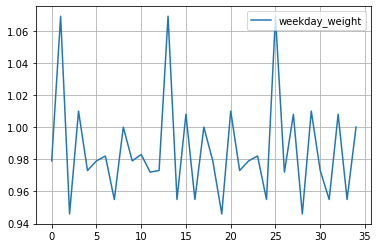

In [14]:
days_by_month.plot(y='weekday_weight',kind='line',grid=True)
done=True

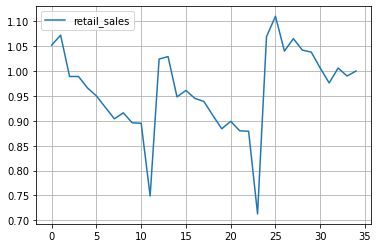

In [15]:
days_by_month.plot(y='retail_sales',kind='line',grid=True)
done=True

In [17]:

days_by_month['week_retail_weight'] = days_by_month.weekday_weight * days_by_month.retail_sales

print(days_by_month.shape)
print(days_by_month.head(),'\n')
print(days_by_month.tail())

(35, 15)
   month  year  season  MoY  days_in_M  Suns_in_M  Mons_in_M  Tues_in_M  Weds_in_M  Thus_in_M  Fris_in_M  Sats_in_M  weekday_weight  retail_sales  week_retail_weight
0      0  2013       2    1         31          4          4          5          5          5          4          4           0.979         1.052               1.030
1      1  2013       3    2         28          4          4          4          4          4          4          4           1.069         1.072               1.146
2      2  2013       0    3         31          5          4          4          4          4          5          5           0.946         0.989               0.936
3      3  2013       1    4         30          4          5          5          4          4          4          4           1.010         0.989               0.999
4      4  2013       2    5         31          4          4          4          5          5          5          4           0.973         0.966               0

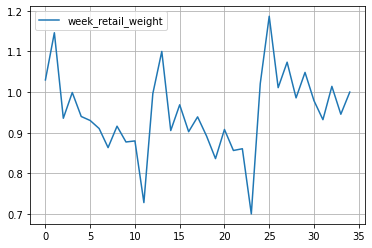

In [18]:
days_by_month.plot(y='week_retail_weight',kind='line',grid=True)
done=True

In [20]:
# to normalize sales per month by number of days in month (28-31), multiply by ( 30 / (column "days_in_M"))
# to normalize sales per month by number of days in month, number of each weekday (Sun, Mon, Tues...) in month (mean sales over all 34 train months), multiply by column "weekday_weight"
# to normalize sales per month by recorded retail sales per month numbers for Russia, multiply by column "retail_sales"
# to normalize sales per month by number of days in month (28-31), number of each weekday (mean sales over all 34 train months), and retail sales numbers for Russia, multiply by column "week_retail_weight"

from google.colab import drive
drive.mount("/content/drive")

GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
%cd "{GDRIVE_REPO_PATH}"

days_by_month.to_csv("data_output/days_by_month.csv", index=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag
